# Domain Related Regessions
> Part 3 of the mangoes_blog project

- branch: master
- toc: true 
- badges: false
- comments: false
- sticky_rank: 3
- author: Huon Fraser
- categories: [mangoes]

In this previous part, we introduced the Mangoes data set, performed explanatory analysis for the metadata, defined our evaluation approach and built a linear model. In this part, we extend the linear model by using Partial Least Squares (PLS) preprocessing and local sample weightings.

In [1]:
#collapse-hide
import pathlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import sys
sys.path.append('/notebooks/Mangoes/src/')
model_path  = '../models/'


from codetiming import Timer
from sklearn.model_selection import GroupKFold
from scikit_models import *
from skopt.space import Real, Integer
from lwr import LocalWeightedRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#collapse-hide
mangoes=load_mangoes()

train_data,test_data = train_test_split(mangoes)
train_X, train_y, train_cat = X_y_cat(train_data,min_X=684,max_X=990)
test_X, test_y, test_cat = X_y_cat(test_data,min_X=684,max_X=990)
nrow,ncol=train_X.shape
groups = train_cat['Pop']
splitter=GroupKFold()


## Partial Least Squares

PLS is like a supervised equivalent to principal components (PCA) and is widely used for IR-spectra analysis. Like PCA, a change of basis is performed with features transformed along orthogonal axes. The difference between the two is that while PCA selects components that explain variance within X, PLS selects components from X that explain variance within y, making features extracted by PLS more suitable for regression.

We make a small change to the sklearn PLS implementation as it doesn't play nice with the Pipeline class; being a supervised learner, PLS transforms and returns both X and y in a tuple. Future steps in the pipeline expect only the transformed X values.

In [3]:
from sklearn.cross_decomposition import PLSRegression as PLS_

class PLSRegression(PLS_):
    
    def transform(self,X,y=None,copy=True):
        X = super().transform(X,copy=copy)
        return X

The optimial model takes 30 components, with a moderate amount of $l_2$ regularisation. Search took around 5 minutes (this varies by run), an order of magnitude more than the search run last post. In future approaches we may want to run PLS only once with 30 components so that for PLS we fit and transform the data only once. 

  0%|          | 0/50 [00:00<?, ?it/s]

Best model had an MSE of 0.8116
Setting parameters as: {'scaler__n_components': 35, 'model__alpha': 0.27337815806191307}
Elapsed time: 275.3796 seconds


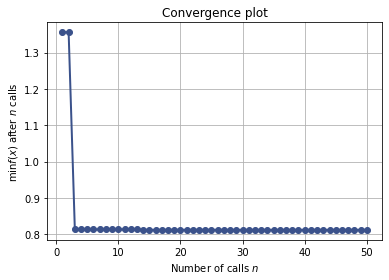

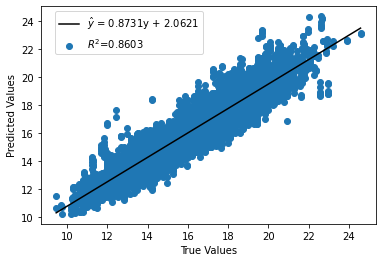

In [4]:
from sklearn.linear_model import Ridge

pls= Pipeline([('scaler', PLSRegression(n_components=10)),     
                 ('model', Ridge())
                ])

space = [Integer(2,ncol,name='scaler__n_components'),
          Real(1e-3, 1e3, name='model__alpha',prior='log-uniform')
         ]

opt = Optimiser(space,pls,train_X,train_y,splitter=splitter,groups=groups)
model_pls,result_pls = opt.optimise(save_file=model_path+'3_pls')

## Locally Weighted Regression

Another method to improve a linear regression is to use lazily calculated local instance weights. Rather than training a single, global, model, we define a model that takes unique weights for each prediction instance. This can be done in any number of ways. The approach we take is to use Euclidean distance between and assign the k closest training instances a weight of 1 and the rest weight of 0. An intuitive way to understand this is as a kNN model with voting done by linear regression.  At train time, we store the training set. At test time, we calculate our closest k-neighbours on which a linear regression is trained.

The advantage of this local weighting approach is that we can avoid outliers in the training data, which may skew a linear model. This approach also better fits non-linear data, as we can create a globally non-linear model from locally linear parts. The downsides of this approach are that we increase the cost of making predictions, the model is less interpretable, and we can run into neighbourhood effects when data is less dense.

We run a search with the number of neighbours k ranging from 1 to $\frac{4}{5}nrow$, the size of each training set in cross-validation. Note that this is incredibly inefficient for large values of k. We find that an LWR is useless in this application.

  0%|          | 0/50 [00:00<?, ?it/s]

Best model had an MSE of 0.7868
Setting parameters as: {'scaler__with_mean': 0, 'scaler__with_std': 1, 'model__alpha': 0.0024967728668762105, 'model__n_neighbours': 4668}
Elapsed time: 17004.9833 seconds


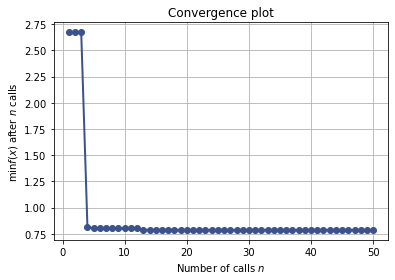

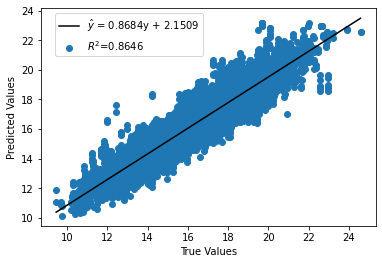

In [5]:
from sklearn.preprocessing import StandardScaler
lwr= Pipeline([('scaler',StandardScaler()),
                ('model',LocalWeightedRegression())
              ])
space  = [Integer(0,1,name='scaler__with_mean'),
          Integer(0,1,name='scaler__with_std'),
          Real(1e-3, 1e3, name='model__alpha',prior='log-uniform'),
          Integer(1, nrow*4/5, name='model__n_neighbours')
         ]

opt = Optimiser(space,lwr,train_X,train_y,splitter=splitter,groups=groups)
model_lwr,result_lwr= opt.optimise(save_file=model_path+'3_lwr')

## PLS and LWR 
We now combine PLS and LWR models, giving an MSE score of 0.7590. Interestingly our model uses more components (71 rather than 31) than in the previous example.

In [ ]:
plslwr =  Pipeline([('scaler',PLSRegression()),
                    ('model',LocalWeightedRegression())
                   ])

space  = [Integer(1,ncol,name='scaler__n_components'),
          Integer(1,nrow*4/5,name='model__n_neighbours'),
          Real(1e-3, 1e3, name='model__alpha',prior='log-uniform')
         ]
opt = Optimiser(space,plslwr,train_X,train_y,splitter=splitter,groups=groups)
model_plslwr,result_plslwr = opt.optimise(save_file=model_path+'3_plslwr')

  0%|          | 0/50 [00:00<?, ?it/s]

## Summary

In the previous notebook, we fitted a linear regression with a level of $l_2$ regularisation determined by search. This resulted in a model giving an MSE of 1.1290 on the test set. This notebook has built upon this model by using PLS feature extraction and lazy sample weights, a type of approach that is popular for NIR-spectroscopy problems. Neither technique gave good performance alone, but combined we set a new benchmark for cross-validation performance. On the test set, this approach scored an MSE of 0.8117, an improvement of -0.3173 over the previous notebook.

In [ ]:
plslwr,  mse_test = evaluate(plslwr,train_X,train_y,test_X,test_y,plot=True)